# Implementing a pytorch-like package from scratch
This notebook is from me essentially giving myself a refresher on the linear algebra and multivariate calculus used in neural networks + a review of numpy methods. The intent is not to just implement *a* neural network + backpropagation from scratch, but to make a framework for implementing *any* neural network from scratch *without* class-based abstractions as a challenge. As in: you should be able to add any layer of any size you want, add any activation function, describe any weight initialization, plug in learning rate, specify which layers to freeze/unfreeze etc.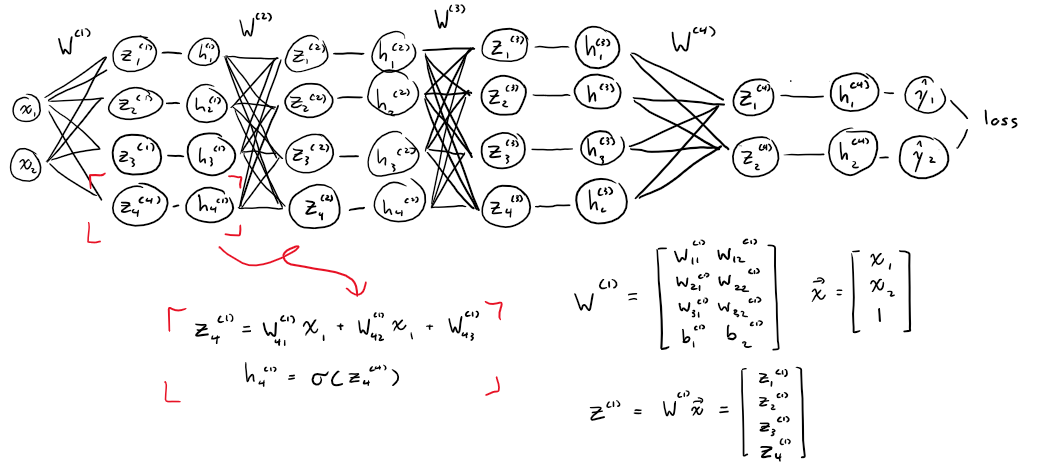

In [10]:
import numpy as np
#only numpy needed, and only numpy used

## Part 1: Demystifying the neural network
---

Originally, neural networks were designed to vaguely mimic how neurons function in brains. Because of this, many tutorials and educational sources teaching neural networks to beginners will emphasize the 'neuron' aspect of the network.

This is a terrible abstraction which is only shallowly intuitive and should be abandoned right away.

To demystify neural networks, it must understood that a neural network is just a series of nested functions performing matrix operations. The conception of a network as some analogy of real neurons is not necessary to understanding this.

We call these functions *layers*. Each layer is responsible for taking in some input vector and returning some output vector.


---




$\text{The Linear Layer}$

The most basic layer is a simple linear function which performs matrix multiplication between some input vector $\vec{x}$ of shape *d* and some weight matrix $W$ of shape *p* by *d*, adds a bias vector **B** value *d*, and returns an output vector $\vec{z}$ of shape *p*.

\begin{align}
\vec{x} = \begin{pmatrix}
          x_1\\
          x_2\\
          \vdots\\
          x_d
          \end{pmatrix}
W = \begin{bmatrix}
        w_{11} & w_{12} & \cdots & w_{1d}\\
        w_{21} & w_{22} & \cdots & w_{2d}\\
        \vdots & \vdots & \ddots & \vdots\\
        w_{p1} & w_{p2} & \cdots & w_{dp}
    \end{bmatrix}
\vec{b} =  
          \begin{pmatrix}
          b_1\\
          b_2\\
          \vdots\\
          b_p
          \end{pmatrix}
\end{align}

\begin{align}
\vec{z} = W\vec{x} + \vec{b} =
          \begin{pmatrix}
          z_1\\
          z_2\\
          \vdots\\
          z_p
          \end{pmatrix}
\end{align}

In terms of how this is implemented programmatically, you'll notice that our function signature
 ```python
def Z(W, X):
```
only takes in a weight matrix and an input matrix but no bias vector. This is because we implement the bias terms as the last row of a weight matrix and concatenate the the input matrix with a row of ones, which is mathematicall identical but saves programmatic abstraction of maintainning a separate bias vector in memory with a separate reference pointer.

Here we also implement gradient tracking. By passing in
```python
tracking_gradient=True
```
the function also computes the gradient with respect to (w.r.t) its input and returns this alongside the output

In [11]:
#weights and biases------------------------------------------------------------
def Z(W, X, track_gradient=True):
    # W is an m by n matrix where m is the output size and n is the input size
    # the last entries in the axis=2 of W is the weights
    # X is an d by b matrix where d is the num features and b is the batch size
    # to add bias we appent ones along axis = 0 of x'
    out = np.matmul(W, np.append(X,np.ones((1,X.shape[1])), axis=0))
    if track_gradient:
      dZ_dX = W
      return(out, dZ_dX)
    else:
      return(out)



---


$\text{Activation Functions}$

Next we describe our activation and loss functions. Activation functions are non-linear functions applied to the output of linear layers, allowing networks to model non-linear relationships. Without these functions, a network would just be your typical linear regressor. The combination of linear layers followed by activation functions are the integral building blocks of all neural networks. We refer to these layers as *hidden layers*.

We implement two such functions below

\begin{align}
\text{ReLU}(x) = \left\{
\begin{array}{cl}
0 & x \le 0 \\
x & x > 0.
\end{array}
\right.
\end{align}

\begin{align}
\text{Sigmoid}(x) = \frac{1}{1 + e^{-x}}
\end{align}

Note: since we have let $\text{z}$ be the output of a linear layer, in our implementation we reference $\text{ReLU}(z)$ to denote applying ReLU to the output of a linear layer. We proceed with this notation in our programmatic implementation

Loss functions are our objective functions. They take the vector outputs of the neural network $\hat{y}$, compare it against what it should be ${y}$, and return a number. In general: the more incorrect, the higher the number. We implement one such function called mean squared error in this project.

\begin{align}
\text{MSE}(y, \hat{y}) = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2.
\end{align}


In [12]:
#activation functions----------------------------------------------------------
def relu(Z, track_gradient=True):
    if track_gradient:
      #we define the derivative of ReLU to be 0 in all flat regions, else 1
      dH_dZ = np.where(Z<=0, 0, 1)
      out = np.multiply(dH_dZ, Z)
      return(out, dH_dZ)
    else:
      return(np.minimum(Z,0))

#leaky relu is a relu variant where the flat portion is not entirely flat
#this is to avoid dead relu problem
def leaky_relu(Z, m=0.01,track_gradient=True):
    if track_gradient:
      dH_dZ = np.where(Z<=0, m*Z, 1)
      out = np.multiply(dH_dZ, Z)
      return(out, dH_dZ)
    else:
      return(np.minimum(Z,m*Z))

def sigmoid(Z, track_gradient=True):
    out = 1/(1+np.exp(-1*Z))
    if track_gradient:
      dH_dZ = 1 - out
      return(out, dH_dZ)
    else:
      return(out)

#loss functions----------------------------------------------------------------
def MSE(y, y_hat):
    error = y-y_hat
    squared_error = error*error
    mean_squared_error = np.sum(squared_error)/y.shape[1]
    return(mean_squared_error, 2*(error)/y.shape[1])

## Part 2: Implementing Feed Forward
---

We now have all the basic building blocks of the neural network; enough to implement the core function of all neural networks: *feed forward*.



*Feed forward* refers to the act of passing in some input into the neural network and getting some output. IE: given some initial input vector $\vec{x}$, to retrieve $\hat{y}$, we simply pass our input vector to the very first layer of the network, get its output, then pass that to the next layer as its input, and repeat until the last layer is reached.

---


There are multiple programmatic abstractions and ways to implement feed forward. What you choose will mostly depend on how you have chosen to model your network in terms of ADT. For instance: if you're abstracting your network as a linked list of layers, then you may want to implement feed forward as a recursive function. In our case, we abstract our network as a list of layers and layers as dictionaries/hashmaps.

For instance: below is how we would describe a neural network of two hidden layers of width 5, using ReLU and MSE loss.

```python
example_net = [
    {'input' : X,
     'gradient':True,
     'output':True},

    {'weight' : init_weights_biases(input_dims, 5, option='random'),
     'gradient':True,
     'output':True},

     {'activation' : relu,
      'gradient':True,
      'output':True},

    {'weight' : init_weights_biases(5, output_dims, option='random'),
     'gradient':True,
     'output':True},

    {'loss' : MSE,
     'Y': Y,
     'gradient':True,
     'output':True}
]
```
With this, we can describe feed forward as a function that iterates through each layer in the list, retrieves its output, stores it, and feeds it to the next layer in the list until we've reached the end of the list.

In [13]:
#just a function describing various weight initialization paradigms
#in general, setting weights to be all zeros or ones is a bad idea
def init_weights_biases(in_dim, out_dim, option=''):
    if option == 'random':
      return(np.random.normal(0,0.5,size=(out_dim, in_dim+1)))
    elif option == 'zero':
      return(np.zeros((out_dim, in_dim+1)))
    elif option == 'ones':
      return(np.ones((out_dim, in_dim+1)))
    elif option == 'zero_bias':
      return(np.append(np.ones((out_dim, in_dim)),np.zeros((out_dim,1)), axis=1))
    else:
      return(np.random.normal(0,0.5,size=(out_dim, in_dim+1)))
def get_layer_output(layer, X, in_eval_mode=False):
    if not in_eval_mode:
      if 'weight' in layer:
          W = layer['weight']
          return(Z(W, X))
      elif 'activation' in layer:
          return(layer['activation'](X))
      elif 'loss' in layer:
          return(layer['loss'](layer['Y'], X))
    else:
      if 'weight' in layer:
          W = layer['weight']
          return(Z(W, X, track_gradient=False))
      elif 'activation' in layer:
          return(layer['activation'](X, track_gradient=False))
    return(X,True)
def feed_forward(network, X, in_eval_mode=False):
  for layer in network:
      output, gradient = get_layer_output(layer, X, in_eval_mode)
      layer['output'] = output
      layer['gradient'] = gradient
      X = output

## Part 3: Gradient Descent and Back Propagation
---

Once you see layers as just functions of vectors, gradient descent becomes a whole of a lot easier. Because what we can then do is implement gradient descent as a chain rule of jacobian matrices!

This is also why I absolutely hate the view of neural networks as being consisting of individual neurons. It makes gradient descent way harder to abstract. It's one of the rare cases where the simplified abstraction hurts the learner's understanding more than just introducing the real math


---



In [14]:
def back_propagate(network, verbose=False, lr=0.0005):
  delta = 1
  layer_num = len(network)-1
  for layer in reversed(network):
    #delta here is always of shape d by b
    if 'weight' in layer:
      layer_gradient = layer['gradient']
      #delta is d[layer+1] by b
      #prev layer is d[layer]+1 by b
      #for the bias term
      prev_layer_activation = network[layer_num-1]['output']
      prev_layer_activation = np.append(
          prev_layer_activation,
          np.ones((1,prev_layer_activation.shape[1]
          )), axis=0
      )
      #need to turn this shit into a d[layer+1] by d[layer]+1 by b matrix
      prev_dim, batch_dim = prev_layer_activation.shape
      delta_dim = delta.shape[0]
      reshape_prev_layer_activation = prev_layer_activation.reshape(1,prev_dim,batch_dim).repeat(delta_dim,axis=0)
      reshaped_delta = delta.reshape(delta_dim,1,batch_dim).repeat(prev_dim,axis=1)
      # (d.reshape(2,1,3).repeat(13,axis=1)
      #*
      # inp.reshape(1,13,3).repeat(2,axis=0)).mean(axis=2)
      update = (reshape_prev_layer_activation*reshaped_delta).mean(axis=2)

      weight = layer['weight']
      if verbose:
        print(f'\n\nThis is the delta: \n{delta}')
        print(f'\n\nThis is input: \n{prev_layer_activation}')
        print(f'\n\nThis is weights pre update: \n{weight}')
        print(f'\n\nThis is the update: \n{update}')

      layer['weight'] = layer['weight'] + update*lr

      delta = np.matmul(layer_gradient[:,:-1].T,delta)
    else:
      layer_gradient = layer['gradient']
      delta = delta * layer_gradient
    layer_num-=1
  return(delta)

In [15]:
num_features = 12
num_examples = 30
out_shape = 2
X = np.array(np.random.normal(0,1,size=(num_features,num_examples)))
# true_params = np.array([[1,-2,3,-4,5,-6,7,-8,9,-10,11,-12],
#                         [-1,2,-3,4,-5,6,-7,8,-9,10,-11,12]])
true_params = np.random.normal(1,0.5,size=(out_shape,num_features))
print(true_params)
Y = np.matmul(true_params,X)

[[ 1.10455981  0.53977659  0.77312552  0.58562689  0.5588192   0.67658713
   0.93756626  2.18252412  0.95552968  0.64690779  0.8400359   0.94270785]
 [ 1.17355566  0.30267707  1.72644004  0.83634422  0.94860696  0.62638695
  -0.12579635  0.97510087  0.94268623  1.44739382  1.77021346  0.95229144]]


## Tada!

And ther we have it, we now have a walmart-version of Pytorch's sequential API. Using this it is posisble to build most basic fully connected networks as a list of layers.

In [16]:
learner_network = [
    {'input' : X,
     'gradient':True,
     'output':True},

    {'weight' : init_weights_biases(num_features, 24, option='random'),
     'gradient':True,
     'output':True},

     {'activation' : relu,
      'gradient':True,
      'output':True},

    {'weight' : init_weights_biases(24, 6, option='random'),
     'gradient':True,
     'output':True},

     {'activation' : relu,
      'gradient':True,
      'output':True},

    {'weight' : init_weights_biases(6, out_shape, option='random'),
     'gradient':True,
     'output':True},

    {'loss' : MSE,
     'Y': Y,
     'gradient':True,
     'output':True}
]
feed_forward(learner_network, X)
# print(learner_network[-2]['output'].T)
loss = learner_network[-1]['output']
print(f'This is our loss BEFORE trainning: {loss}')

This is our loss BEFORE trainning: 27.6755130710348


In [17]:
from tqdm import tqdm
for epoch in tqdm(range(5000)):
  feed_forward(learner_network, X)

  out = learner_network[-2]['output'].T
  loss = learner_network[-1]['output']

  lr = 0.001
  if epoch % 100 == 0 and epoch != 0:
    lr=lr*5
    back_propagate(learner_network, lr=lr)
  else:
    back_propagate(learner_network, lr=lr)

loss = learner_network[-1]['output']
out = learner_network[-2]['output'].T

print(f'\nThis is our loss AFTER trainning: {loss}')
# print(f'\nout: \n{out}')
# print(Y.T)

100%|██████████| 5000/5000 [00:01<00:00, 2922.82it/s]


This is our loss AFTER trainning: 3.985774862279676
